<b>Characteristic Curves & Astronomical Objects</b><br><br>
This computational exercise is a way to get to know my data set better. We will plot the raw light curve and the Multiband Lomb Scargle fit for up to five samples of each class. The goal is to identify common characteristics of each object type, both from this empirical analysis and from outside research. This will help me engineer features that I want to input into the classification algorithm. The information I want to extract in this part is period, period score, and mean skew for each class but I have yet to implement these averages. <br><br>
Here I have essentially shown the methodology that I will use to process each sample, but I think that I can streamline this code a lot. In fact, I plan to condense the object type analysis to a single function so that I can perform it on command in the "Main" Jupyter notebook.

In [30]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
plt.style.use('seaborn-whitegrid')
from gatspy import datasets, periodic

In [37]:
train_series = pd.read_csv('training_set.csv')
train_series = train_series.sort_values(['object_id', 'passband'], ascending = [True, True])

train_metadata = pd.read_csv('training_set_metadata.csv')

train_series.head()
print(train_metadata['target'].unique())

[92 88 42 90 65 16 67 95 62 15 52  6 64 53]


In [38]:
#combine time series data and merge with metadata

#create arrays for object id and passband through which to iterate
ids = train_metadata['object_id'].values
types = train_metadata['target'].unique()
passbands = [0, 1, 2, 3, 4, 5]

#append mjd, flux, and flux_err values per passband per object to the metadata
for band in passbands:
    mjd_column = []
    flux_column = []
    fluxerr_column = []
    for obj in ids:
        selection = train_series.loc[(train_series['object_id'] == obj) & (train_series['passband'] == band)]
        mjd_column.append(np.array(selection['mjd']))
        flux_column.append(np.array(selection['flux']))
        fluxerr_column.append(np.array(selection['flux_err']))
    train_metadata['mjd_passband_{}'.format(band)] = mjd_column
    train_metadata['flux_passband_{}'.format(band)] = flux_column
    train_metadata['fluxerr_passband_{}'.format(band)] = fluxerr_column
    
train_metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,fluxerr_passband_2,mjd_passband_3,flux_passband_3,fluxerr_passband_3,mjd_passband_4,flux_passband_4,fluxerr_passband_4,mjd_passband_5,flux_passband_5,fluxerr_passband_5
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,...,"[3.6229519999999997, 4.0412040000000005, 3.462...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[-471.385529, -524.95459, -475.51605199999995,...","[3.8012129999999997, 3.552751, 3.340643, 3.736...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[-388.984985, -393.480225, -405.663818, -400.2...","[11.395031, 3.5993459999999997, 3.496113, 3.83...","[59752.4435, 59767.3343, 59770.2557, 59779.356...","[-355.88678, -421.199066, -415.286896, -422.81...","[10.421921000000001, 6.377517, 7.435979, 8.124..."
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,...,"[1.013889, 1.196956, 1.110572, 0.9227790000000...","[59825.2752, 59839.2313, 59842.214, 59854.2242...","[6.673630999999999, 6.108739, 5.311658, 4.7686...","[1.932316, 1.789895, 1.683777, 1.422675, 2.280...","[59825.2862, 59839.2422, 59842.225, 59854.2351...","[5.214194, 8.283792, 4.6809080000000005, 4.065...","[3.0180029999999998, 2.5279529999999997, 2.349...","[59825.2971, 59839.2532, 59842.2359, 59854.246...","[12.060948, 9.6865, 6.9215029999999995, 1.2903...","[7.163382, 5.882469, 5.573885, 3.980583, 5.174..."
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,...,"[1.3643, 2.4605759999999997, 0.925337000000000...","[59798.3357, 59801.3705, 59826.3258, 59842.260...","[2.939447, -1.8992189999999998, 0.972355, -0.2...","[1.7713279999999998, 2.292693, 1.513987, 1.325...","[59798.3466, 59801.3815, 59826.3367, 59842.271...","[2.128097, 2.2849060000000003, -0.570261, 2.01...","[2.610659, 2.523534, 2.162375, 2.173066, 2.778...","[59798.3576, 59801.3924, 59826.3477, 59842.282...","[-12.809639, 5.203419, -2.301237, 10.142254, 3...","[5.380097, 5.395980000000001, 5.548611, 6.0863..."
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,...,"[0.619084, 2.049559, 1.218648, 0.984894, 2.289...","[59770.3817, 59779.4151, 59782.2527, 59797.348...","[-1.623621, 7.149203999999999, -2.479718, -4.9...","[1.051044, 2.4555860000000003, 2.05788, 1.6823...","[59770.3928, 59779.4261, 59782.2639, 59797.359...","[2.732148, -0.61228, 0.182858, -0.577881000000...","[1.8072720000000002, 3.2633419999999997, 2.552...","[59770.4039, 59779.437, 59782.2751, 59797.3708...","[0.529565, 12.491076, -2.357999, -5.3403220000...","[4.609781, 8.552037, 6.309989, 5.2788410000000..."
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,...,"[1.531847, 1.083173, 0.896293, 2.069243, 2.358...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[0.415283, -2.154332, 4.11005, -1.41784, 0.625...","[2.331983, 1.479982, 1.3569200000000001, 2.169...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[-16.543753, -0.003135, -0.012235, 0.706615, -...","[10.423373, 2.371642, 2.161318, 2.694045, 2.99...","[59752.4435, 59767.3343, 59770.2557, 59779.356...","[-4.988304, 1.264989, 3.5211580000000002, 0.70...","[9.556839, 5.028581, 6.333658, 7.1397639999999..."


In [41]:
type_42 = train_metadata.loc[train_metadata['target'] == 42]
type_42.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,...,fluxerr_passband_2,mjd_passband_3,flux_passband_3,fluxerr_passband_3,mjd_passband_4,flux_passband_4,fluxerr_passband_4,mjd_passband_5,flux_passband_5,fluxerr_passband_5
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,...,"[1.3643, 2.4605759999999997, 0.925337000000000...","[59798.3357, 59801.3705, 59826.3258, 59842.260...","[2.939447, -1.8992189999999998, 0.972355, -0.2...","[1.7713279999999998, 2.292693, 1.513987, 1.325...","[59798.3466, 59801.3815, 59826.3367, 59842.271...","[2.128097, 2.2849060000000003, -0.570261, 2.01...","[2.610659, 2.523534, 2.162375, 2.173066, 2.778...","[59798.3576, 59801.3924, 59826.3477, 59842.282...","[-12.809639, 5.203419, -2.301237, 10.142254, 3...","[5.380097, 5.395980000000001, 5.548611, 6.0863..."
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,...,"[1.5217889999999998, 1.0762399999999999, 0.891...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[7.900053, 6.093955, 2.303503, 3.776408, 5.707...","[2.323994, 1.476641, 1.349553, 2.1605540000000...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[17.082548000000003, 11.917011, 13.469202, 6.4...","[10.393328, 2.368002, 2.159659, 2.686464, 2.99...","[59752.4435, 59767.3343, 59770.2557, 59779.356...","[34.559826, 16.413616, 29.175065999999998, 9.4...","[9.541461, 5.021657, 6.32641, 7.1217, 7.603939..."
11,2103,346.500000,-62.320400,321.951129,-50.736054,1,0.1695,0.5409,0.2283,42.4667,...,"[1.519395, 1.075006, 0.889417, 2.053984, 2.340...","[59750.4383, 59752.4224, 59767.3122, 59770.233...","[-0.025047999999999997, -0.471242, -3.27953700...","[2.318289, 1.4713379999999998, 1.346635, 2.156...","[59750.445, 59752.4334, 59767.3233, 59770.2445...","[12.66208, -0.635663, -0.7464270000000001, 3.5...","[10.381752, 2.3610919999999997, 2.151704999999...","[59752.4435, 59767.3343, 59770.2557, 59779.356...","[-2.004368, 5.720166000000001, 1.570745, 17.89...","[9.520899, 5.011933, 6.309080000000001, 7.1193..."
12,2300,359.446716,-44.201530,331.730015,-69.805709,1,0.2360,2.7474,0.5335,46.7959,...,"[0.627422, 2.066958, 1.230078, 0.993859, 2.308...","[59770.3817, 59779.4151, 59782.2527, 59797.348...","[18.823622, 15.297647, 13.676468, 14.888254000...","[1.074484, 2.474416, 2.076924, 1.700853, 2.471...","[59770.3928, 59779.4261, 59782.2639, 59797.359...","[18.912529, 16.704607, 20.846098, 15.499054999...","[1.8249630000000001, 3.284035, 2.5733490000000...","[59770.4039, 59779.437, 59782.2751, 59797.3708...","[14.538424, 32.116859000000005, 18.49183500000...","[4.636243, 8.593544999999999, 6.343386, 5.3081..."
18,3285,150.820312,1.641510,237.994507,42.358984,1,0.1610,0.1818,0.0079,39.7258,...,"[1.1437700000000002, 1.882526, 2.190634, 1.048...","[59588.2343, 59591.2244, 59594.2796, 59618.210...","[1.441665, 0.814851, 3.15278, 1.91432599999999...","[1.537717, 2.020781, 2.503002, 1.834973, 2.712...","[59588.2452, 59591.2353, 59594.2905, 59618.221...","[-1.67629, -1.190451, -4.252527, -3.962049, -0...","[2.190075, 2.840445, 2.967551, 2.837016, 2.828...","[59588.2562, 59591.2463, 59594.3015, 59618.232...","[6.479928, 4.126997, -1.91182, -3.489175, 1.42...","[5.791847, 5.870399, 7.018451, 6.5544289999999..."


In [70]:
def fit_multiband(obj, series):
    event = series.loc[series['object_id'] == obj]
    t = event['mjd']
    f = event['flux']
    e = event['flux_err']
    b = event['passband']
    upper_lim = (0.5 * 3 * len(t))/(t.max()-t.min())
    
    model = periodic.LombScargleMultibandFast(fit_period=True)
    model.optimizer.period_range = (0.1, int((t.max()-t.min())/2))
    model.fit(t, f, e, b)
    
    periods = np.linspace(0, upper_lim, 1000)
    power = model.periodogram(periods)
    ideal = model.best_period
    best_periods = model.find_best_periods()
    
    return [model, best_periods, periods, power, ideal]

Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42684 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set 

Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42684 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 1990 steps


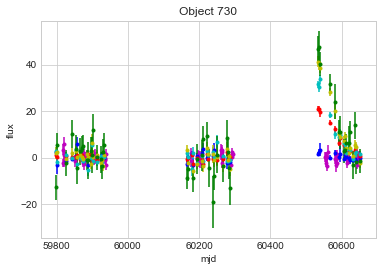

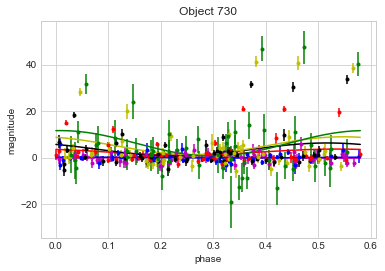

In [71]:
plt.figure(0)
plt.title('Object 730')
plt.xlabel('mjd')
plt.ylabel('flux')

plt.errorbar(x = type_42.loc[2, 'mjd_passband_0'], y = type_42.loc[2, 'flux_passband_0'], yerr = type_42.loc[2, 'fluxerr_passband_0'], fmt='m.')
plt.errorbar(x = type_42.loc[2, 'mjd_passband_1'], y = type_42.loc[2, 'flux_passband_1'], yerr = type_42.loc[2, 'fluxerr_passband_1'], fmt='b.')
plt.errorbar(x = type_42.loc[2, 'mjd_passband_2'], y = type_42.loc[2, 'flux_passband_2'], yerr = type_42.loc[2, 'fluxerr_passband_2'], fmt='r.')
plt.errorbar(x = type_42.loc[2, 'mjd_passband_3'], y = type_42.loc[2, 'flux_passband_3'], yerr = type_42.loc[2, 'fluxerr_passband_3'], fmt='c.')
plt.errorbar(x = type_42.loc[2, 'mjd_passband_4'], y = type_42.loc[2, 'flux_passband_4'], yerr = type_42.loc[2, 'fluxerr_passband_4'], fmt='y.')
plt.errorbar(x = type_42.loc[2, 'mjd_passband_5'], y = type_42.loc[2, 'flux_passband_5'], yerr = type_42.loc[2, 'fluxerr_passband_5'], fmt='g.')

[model, best_periods, periods, power, upper_lim, ideal] = fit_multibands(730, train_series)

plt.figure(1)
plt.title('Object 730')
plt.xlabel('phase')
plt.ylabel('magnitude')

plt.errorbar(x = type_42.loc[2, 'mjd_passband_0'] % upper_lim, y = type_42.loc[2, 'flux_passband_0'], yerr = type_42.loc[2, 'fluxerr_passband_0'], fmt='m.')
yfit = model.predict(periods, 0, period = upper_lim)
plt.plot(periods, yfit, color = 'm')

plt.errorbar(x = type_42.loc[2, 'mjd_passband_1'] % upper_lim, y = type_42.loc[2, 'flux_passband_1'], yerr = type_42.loc[2, 'fluxerr_passband_1'], fmt='b.')
yfit = model.predict(periods, 1, period = upper_lim)
plt.plot(periods, yfit, color = 'b')
 
plt.errorbar(x = type_42.loc[2, 'mjd_passband_2'] % upper_lim, y = type_42.loc[2, 'flux_passband_2'], yerr = type_42.loc[2, 'fluxerr_passband_2'], fmt='r.')
yfit = model.predict(periods, 2, period = upper_lim)
plt.plot(periods, yfit, color = 'r')
 
plt.errorbar(x = type_42.loc[2, 'mjd_passband_3'] % upper_lim, y = type_42.loc[2, 'flux_passband_3'], yerr = type_42.loc[2, 'fluxerr_passband_3'], fmt='k.')
yfit = model.predict(periods, 3, period = upper_lim)
plt.plot(periods, yfit, color = 'k')

plt.errorbar(x = type_42.loc[2, 'mjd_passband_4'] % upper_lim, y = type_42.loc[2, 'flux_passband_4'], yerr = type_42.loc[2, 'fluxerr_passband_4'], fmt='y.')
yfit = model.predict(periods, 4, period = upper_lim)
plt.plot(periods, yfit, color = 'y')

plt.errorbar(x = type_42.loc[2, 'mjd_passband_5'] % upper_lim, y = type_42.loc[2, 'flux_passband_5'], yerr = type_42.loc[2, 'fluxerr_passband_5'], fmt='g.')
yfit = model.predict(periods, 5, period = upper_lim)
plt.plot(periods, yfit, color = 'g')

Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set 

Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 1990 steps


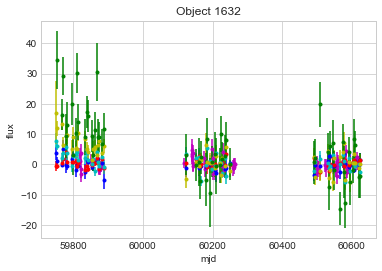

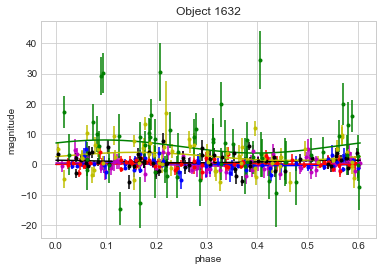

In [73]:
plt.figure(0)
plt.title('Object 1632')
plt.xlabel('mjd')
plt.ylabel('flux')

plt.errorbar(x = type_42.loc[7, 'mjd_passband_0'], y = type_42.loc[7, 'flux_passband_0'], yerr = type_42.loc[7, 'fluxerr_passband_0'], fmt='m.')
plt.errorbar(x = type_42.loc[7, 'mjd_passband_1'], y = type_42.loc[7, 'flux_passband_1'], yerr = type_42.loc[7, 'fluxerr_passband_1'], fmt='b.')
plt.errorbar(x = type_42.loc[7, 'mjd_passband_2'], y = type_42.loc[7, 'flux_passband_2'], yerr = type_42.loc[7, 'fluxerr_passband_2'], fmt='r.')
plt.errorbar(x = type_42.loc[7, 'mjd_passband_3'], y = type_42.loc[7, 'flux_passband_3'], yerr = type_42.loc[7, 'fluxerr_passband_3'], fmt='c.')
plt.errorbar(x = type_42.loc[7, 'mjd_passband_4'], y = type_42.loc[7, 'flux_passband_4'], yerr = type_42.loc[7, 'fluxerr_passband_4'], fmt='y.')
plt.errorbar(x = type_42.loc[7, 'mjd_passband_5'], y = type_42.loc[7, 'flux_passband_5'], yerr = type_42.loc[7, 'fluxerr_passband_5'], fmt='g.')

[model, best_periods, periods, power, upper_lim, ideal] = fit_multibands(1632, train_series)

plt.figure(1)
plt.title('Object 1632')
plt.xlabel('phase')
plt.ylabel('magnitude')

plt.errorbar(x = type_42.loc[7, 'mjd_passband_0'] % upper_lim, y = type_42.loc[7, 'flux_passband_0'], yerr = type_42.loc[7, 'fluxerr_passband_0'], fmt='m.')
yfit = model.predict(periods, 0, period = upper_lim)
plt.plot(periods, yfit, color = 'm')

plt.errorbar(x = type_42.loc[7, 'mjd_passband_1'] % upper_lim, y = type_42.loc[7, 'flux_passband_1'], yerr = type_42.loc[7, 'fluxerr_passband_1'], fmt='b.')
yfit = model.predict(periods, 1, period = upper_lim)
plt.plot(periods, yfit, color = 'b')
 
plt.errorbar(x = type_42.loc[7, 'mjd_passband_2'] % upper_lim, y = type_42.loc[7, 'flux_passband_2'], yerr = type_42.loc[7, 'fluxerr_passband_2'], fmt='r.')
yfit = model.predict(periods, 2, period = upper_lim)
plt.plot(periods, yfit, color = 'r')
 
plt.errorbar(x = type_42.loc[7, 'mjd_passband_3'] % upper_lim, y = type_42.loc[7, 'flux_passband_3'], yerr = type_42.loc[7, 'fluxerr_passband_3'], fmt='k.')
yfit = model.predict(periods, 3, period = upper_lim)
plt.plot(periods, yfit, color = 'k')

plt.errorbar(x = type_42.loc[7, 'mjd_passband_4'] % upper_lim, y = type_42.loc[7, 'flux_passband_4'], yerr = type_42.loc[7, 'fluxerr_passband_4'], fmt='y.')
yfit = model.predict(periods, 4, period = upper_lim)
plt.plot(periods, yfit, color = 'y')

plt.errorbar(x = type_42.loc[7, 'mjd_passband_5'] % upper_lim, y = type_42.loc[7, 'flux_passband_5'], yerr = type_42.loc[7, 'fluxerr_passband_5'], fmt='g.')
yfit = model.predict(periods, 5, period = upper_lim)
plt.plot(periods, yfit, color = 'g')

Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set 

Finding optimal frequency:
 - Estimated peak width = 0.00719
 - Using 5 steps per peak; omega_step = 0.00144
 - User-specified period range:  0.1 to 4.4e+02
 - Computing periods at 43681 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 1990 steps


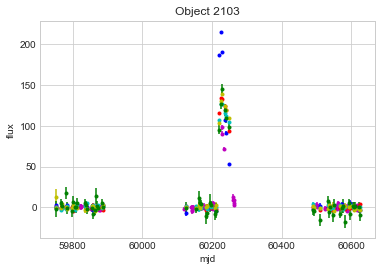

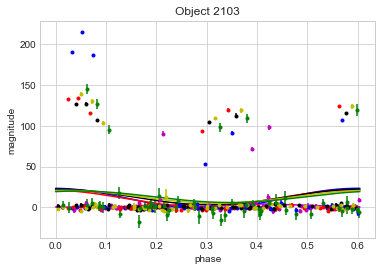

In [75]:

plt.figure(0)
plt.title('Object 2103')
plt.xlabel('mjd')
plt.ylabel('flux')

plt.errorbar(x = type_42.loc[11, 'mjd_passband_0'], y = type_42.loc[11, 'flux_passband_0'], yerr = type_42.loc[11, 'fluxerr_passband_0'], fmt='m.')
plt.errorbar(x = type_42.loc[11, 'mjd_passband_1'], y = type_42.loc[11, 'flux_passband_1'], yerr = type_42.loc[11, 'fluxerr_passband_1'], fmt='b.')
plt.errorbar(x = type_42.loc[11, 'mjd_passband_2'], y = type_42.loc[11, 'flux_passband_2'], yerr = type_42.loc[11, 'fluxerr_passband_2'], fmt='r.')
plt.errorbar(x = type_42.loc[11, 'mjd_passband_3'], y = type_42.loc[11, 'flux_passband_3'], yerr = type_42.loc[11, 'fluxerr_passband_3'], fmt='c.')
plt.errorbar(x = type_42.loc[11, 'mjd_passband_4'], y = type_42.loc[11, 'flux_passband_4'], yerr = type_42.loc[11, 'fluxerr_passband_4'], fmt='y.')
plt.errorbar(x = type_42.loc[11, 'mjd_passband_5'], y = type_42.loc[11, 'flux_passband_5'], yerr = type_42.loc[11, 'fluxerr_passband_5'], fmt='g.')

[model, best_periods, periods, power, upper_lim, ideal] = fit_multibands(2103, train_series)

plt.figure(1)
plt.title('Object 2103')
plt.xlabel('phase')
plt.ylabel('magnitude')

plt.errorbar(x = type_42.loc[11, 'mjd_passband_0'] % upper_lim, y = type_42.loc[11, 'flux_passband_0'], yerr = type_42.loc[11, 'fluxerr_passband_0'], fmt='m.')
yfit = model.predict(periods, 0, period = upper_lim)
plt.plot(periods, yfit, color = 'm')

plt.errorbar(x = type_42.loc[11, 'mjd_passband_1'] % upper_lim, y = type_42.loc[11, 'flux_passband_1'], yerr = type_42.loc[11, 'fluxerr_passband_1'], fmt='b.')
yfit = model.predict(periods, 1, period = upper_lim)
plt.plot(periods, yfit, color = 'b')
 
plt.errorbar(x = type_42.loc[11, 'mjd_passband_2'] % upper_lim, y = type_42.loc[11, 'flux_passband_2'], yerr = type_42.loc[11, 'fluxerr_passband_2'], fmt='r.')
yfit = model.predict(periods, 2, period = upper_lim)
plt.plot(periods, yfit, color = 'r')
 
plt.errorbar(x = type_42.loc[11, 'mjd_passband_3'] % upper_lim, y = type_42.loc[11, 'flux_passband_3'], yerr = type_42.loc[11, 'fluxerr_passband_3'], fmt='k.')
yfit = model.predict(periods, 3, period = upper_lim)
plt.plot(periods, yfit, color = 'k')

plt.errorbar(x = type_42.loc[11, 'mjd_passband_4'] % upper_lim, y = type_42.loc[11, 'flux_passband_4'], yerr = type_42.loc[11, 'fluxerr_passband_4'], fmt='y.')
yfit = model.predict(periods, 4, period = upper_lim)
plt.plot(periods, yfit, color = 'y')

plt.errorbar(x = type_42.loc[11, 'mjd_passband_5'] % upper_lim, y = type_42.loc[11, 'flux_passband_5'], yerr = type_42.loc[11, 'fluxerr_passband_5'], fmt='g.')
yfit = model.predict(periods, 5, period = upper_lim)
plt.plot(periods, yfit, color = 'g')

Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set 

Finding optimal frequency:
 - Estimated peak width = 0.00736
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42677 steps
Zooming-in on 10 candidate peaks:
 - Computing periods at 2000 steps


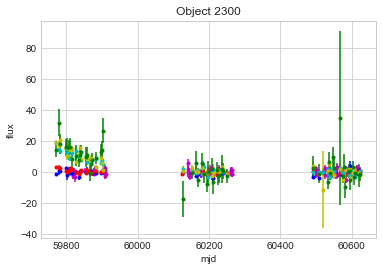

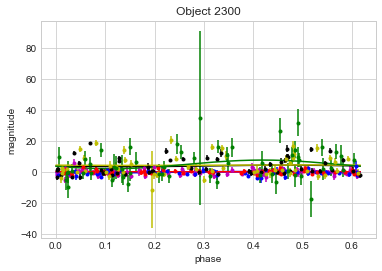

In [76]:
plt.figure(0)
plt.title('Object 2300')
plt.xlabel('mjd')
plt.ylabel('flux')

plt.errorbar(x = type_42.loc[12, 'mjd_passband_0'], y = type_42.loc[12, 'flux_passband_0'], yerr = type_42.loc[12, 'fluxerr_passband_0'], fmt='m.')
plt.errorbar(x = type_42.loc[12, 'mjd_passband_1'], y = type_42.loc[12, 'flux_passband_1'], yerr = type_42.loc[12, 'fluxerr_passband_1'], fmt='b.')
plt.errorbar(x = type_42.loc[12, 'mjd_passband_2'], y = type_42.loc[12, 'flux_passband_2'], yerr = type_42.loc[12, 'fluxerr_passband_2'], fmt='r.')
plt.errorbar(x = type_42.loc[12, 'mjd_passband_3'], y = type_42.loc[12, 'flux_passband_3'], yerr = type_42.loc[12, 'fluxerr_passband_3'], fmt='c.')
plt.errorbar(x = type_42.loc[12, 'mjd_passband_4'], y = type_42.loc[12, 'flux_passband_4'], yerr = type_42.loc[12, 'fluxerr_passband_4'], fmt='y.')
plt.errorbar(x = type_42.loc[12, 'mjd_passband_5'], y = type_42.loc[12, 'flux_passband_5'], yerr = type_42.loc[12, 'fluxerr_passband_5'], fmt='g.')

[model, best_periods, periods, power, upper_lim, ideal] = fit_multibands(2300, train_series)

plt.figure(1)
plt.title('Object 2300')
plt.xlabel('phase')
plt.ylabel('magnitude')

plt.errorbar(x = type_42.loc[12, 'mjd_passband_0'] % upper_lim, y = type_42.loc[12, 'flux_passband_0'], yerr = type_42.loc[12, 'fluxerr_passband_0'], fmt='m.')
yfit = model.predict(periods, 0, period = upper_lim)
plt.plot(periods, yfit, color = 'm')

plt.errorbar(x = type_42.loc[12, 'mjd_passband_1'] % upper_lim, y = type_42.loc[12, 'flux_passband_1'], yerr = type_42.loc[12, 'fluxerr_passband_1'], fmt='b.')
yfit = model.predict(periods, 1, period = upper_lim)
plt.plot(periods, yfit, color = 'b')
 
plt.errorbar(x = type_42.loc[12, 'mjd_passband_2'] % upper_lim, y = type_42.loc[12, 'flux_passband_2'], yerr = type_42.loc[12, 'fluxerr_passband_2'], fmt='r.')
yfit = model.predict(periods, 2, period = upper_lim)
plt.plot(periods, yfit, color = 'r')
 
plt.errorbar(x = type_42.loc[12, 'mjd_passband_3'] % upper_lim, y = type_42.loc[12, 'flux_passband_3'], yerr = type_42.loc[12, 'fluxerr_passband_3'], fmt='k.')
yfit = model.predict(periods, 3, period = upper_lim)
plt.plot(periods, yfit, color = 'k')

plt.errorbar(x = type_42.loc[12, 'mjd_passband_4'] % upper_lim, y = type_42.loc[12, 'flux_passband_4'], yerr = type_42.loc[12, 'fluxerr_passband_4'], fmt='y.')
yfit = model.predict(periods, 4, period = upper_lim)
plt.plot(periods, yfit, color = 'y')

plt.errorbar(x = type_42.loc[12, 'mjd_passband_5'] % upper_lim, y = type_42.loc[12, 'flux_passband_5'], yerr = type_42.loc[12, 'fluxerr_passband_5'], fmt='g.')
yfit = model.predict(periods, 5, period = upper_lim)
plt.plot(periods, yfit, color = 'g')

Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42724 steps


/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_war

Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_war

/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set 

Finding optimal frequency:
 - Estimated peak width = 0.00735
 - Using 5 steps per peak; omega_step = 0.00147
 - User-specified period range:  0.1 to 4.3e+02
 - Computing periods at 42724 steps


/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:445: UserWarning: The score() method defaults to a slower O[N^2] algorithm.
Use the score_frequency_grid() method to access the fast FFT-based algorithm.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("The score() method defaults to a slower O[N^2] "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``sil

Zooming-in on 10 candidate peaks:
 - Computing periods at 1990 steps


/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_war

/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_warnings=True``
  warnings.warn("For smaller datasets, the approximation used by "
/Users/manojna/anaconda/lib/python2.7/site-packages/gatspy/periodic/lomb_scargle_fast.py:429: UserWarning: For smaller datasets, the approximation used by LombScargleFast may not be suitable.
It is recommended to use LombScargle instead.
To silence this warning, set ``silence_war

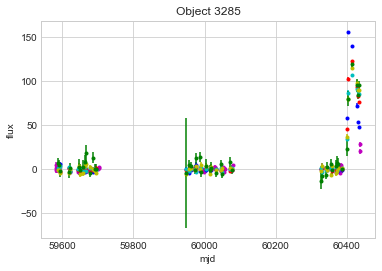

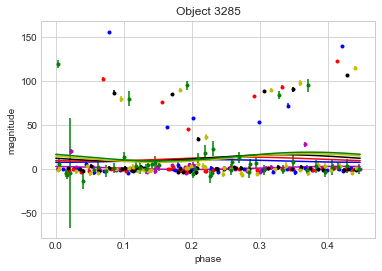

In [77]:

plt.figure(0)
plt.title('Object 3285')
plt.xlabel('mjd')
plt.ylabel('flux')

plt.errorbar(x = type_42.loc[18, 'mjd_passband_0'], y = type_42.loc[18, 'flux_passband_0'], yerr = type_42.loc[18, 'fluxerr_passband_0'], fmt='m.')
plt.errorbar(x = type_42.loc[18, 'mjd_passband_1'], y = type_42.loc[18, 'flux_passband_1'], yerr = type_42.loc[18, 'fluxerr_passband_1'], fmt='b.')
plt.errorbar(x = type_42.loc[18, 'mjd_passband_2'], y = type_42.loc[18, 'flux_passband_2'], yerr = type_42.loc[18, 'fluxerr_passband_2'], fmt='r.')
plt.errorbar(x = type_42.loc[18, 'mjd_passband_3'], y = type_42.loc[18, 'flux_passband_3'], yerr = type_42.loc[18, 'fluxerr_passband_3'], fmt='c.')
plt.errorbar(x = type_42.loc[18, 'mjd_passband_4'], y = type_42.loc[18, 'flux_passband_4'], yerr = type_42.loc[18, 'fluxerr_passband_4'], fmt='y.')
plt.errorbar(x = type_42.loc[18, 'mjd_passband_5'], y = type_42.loc[18, 'flux_passband_5'], yerr = type_42.loc[18, 'fluxerr_passband_5'], fmt='g.')

[model, best_periods, periods, power, upper_lim, ideal] = fit_multibands(3285, train_series)

plt.figure(1)
plt.title('Object 3285')
plt.xlabel('phase')
plt.ylabel('magnitude')

plt.errorbar(x = type_42.loc[18, 'mjd_passband_0'] % upper_lim, y = type_42.loc[18, 'flux_passband_0'], yerr = type_42.loc[18, 'fluxerr_passband_0'], fmt='m.')
yfit = model.predict(periods, 0, period = upper_lim)
plt.plot(periods, yfit, color = 'm')

plt.errorbar(x = type_42.loc[18, 'mjd_passband_1'] % upper_lim, y = type_42.loc[18, 'flux_passband_1'], yerr = type_42.loc[18, 'fluxerr_passband_1'], fmt='b.')
yfit = model.predict(periods, 1, period = upper_lim)
plt.plot(periods, yfit, color = 'b')
 
plt.errorbar(x = type_42.loc[18, 'mjd_passband_2'] % upper_lim, y = type_42.loc[18, 'flux_passband_2'], yerr = type_42.loc[18, 'fluxerr_passband_2'], fmt='r.')
yfit = model.predict(periods, 2, period = upper_lim)
plt.plot(periods, yfit, color = 'r')
 
plt.errorbar(x = type_42.loc[18, 'mjd_passband_3'] % upper_lim, y = type_42.loc[18, 'flux_passband_3'], yerr = type_42.loc[18, 'fluxerr_passband_3'], fmt='k.')
yfit = model.predict(periods, 3, period = upper_lim)
plt.plot(periods, yfit, color = 'k')

plt.errorbar(x = type_42.loc[18, 'mjd_passband_4'] % upper_lim, y = type_42.loc[18, 'flux_passband_4'], yerr = type_42.loc[18, 'fluxerr_passband_4'], fmt='y.')
yfit = model.predict(periods, 4, period = upper_lim)
plt.plot(periods, yfit, color = 'y')

plt.errorbar(x = type_42.loc[18, 'mjd_passband_5'] % upper_lim, y = type_42.loc[18, 'flux_passband_5'], yerr = type_42.loc[18, 'fluxerr_passband_5'], fmt='g.')
yfit = model.predict(periods, 5, period = upper_lim)
plt.plot(periods, yfit, color = 'g')